<h1 align="center">Volume 2: Wavelets.</h1>

    Nathan Schill
    Section 2
    Thurs. Jan. 19, 2023

In [377]:
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
import pywt, copy, itertools
import bitstring as bs
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

# Problem 1:
Write a function that calculates the discrete wavelet transform.
Return a list of one-dimensional NumPy arrays in the form: $[A_n,D_n,...,D_1]$.

Plot the signal of the sine wave given in the problem statement with the approximation and detail coefficients.

In [378]:
def dwt(X, L, H, n):
    """Compute the discrete wavelet transform in one dimension using the Haar 
    wavelet filters.
    
    Parameters:
        X ((m, ) ndarray): A vector of length m on which to perform the 
            wavelet transform.
        L ((2, ) ndarray): Haar father low-pass decomposition filter.
        H ((2, ) ndarray): Haar father high-pass decomposition filter.
        n (int): The number of filter passes to perform.
        
    Returns:
        (list): A list of arrays of length n+1 consisting of the approximation
            coefficients followed by the successive levels of detail
            coefficients.
    """

    # Use Algorithm 9.1 in the lab PDF
    A = X
    D = [None] * n
    for i in range(n):
        D[i] = fftconvolve(A, H)[1::2]
        A = fftconvolve(A, L)[1::2]
    
    return [A] + D[::-1]

In [379]:
# Make a noisy sine wave and compute its discrete wavelet transform below
domain = np.linspace(0, 4*np.pi, 1024)
noise = np.random.randn(1024)*.1
noisysin = np.sin(domain) + noise

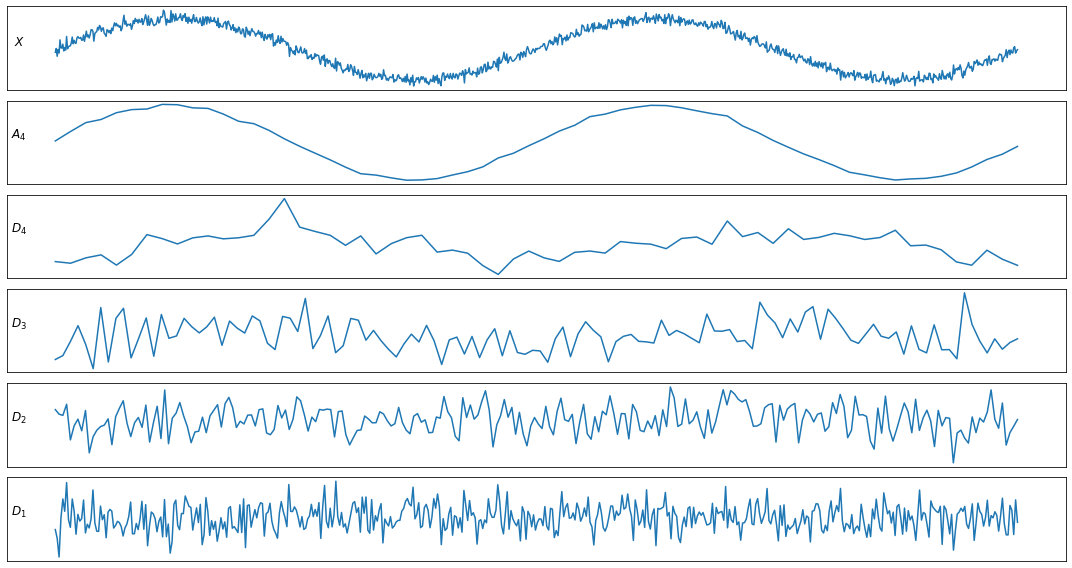

In [380]:
# Define filters
L = np.ones(2)/np.sqrt(2)
H = np.array([-1,1])/np.sqrt(2)

# Define N, obtain coeffs, create plot
N = 4
coeffs = dwt(noisysin, L, H, N)
fig, axs = plt.subplots(N+2, 1)

# Plot X = noisysin
axs[0].plot(domain, noisysin)
axs[0].set_ylabel('$X$', rotation=0, labelpad=-12, fontsize=12)
axs[0].tick_params(axis='both', which='both',
                   bottom=False, top=False, labelbottom=False,
                   left=False, right=False, labelleft=False)

# Create labels
ns = list(range(N, 0, -1))
labels = [f'$A_{N}$'] + [f'$D_{n}$' for n in ns]

for ax, label, data in zip(axs[1:], labels, coeffs):
    # Plot using matching number of points for data
    ax.plot(np.linspace(0, 4*np.pi, len(data)), data)

    # Labels
    ax.set_ylabel(label, rotation=0, labelpad=-12, fontsize=12)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
# Plot
plt.tight_layout()
plt.show()


# Problem 2:
Write a function that performs the inverse wavelet transform.
Return a single array, which represents the recovered single.

Compare the original signal with the signal recovered by the inverse wavelet transform.

In [381]:
def idwt(X, L, H):
    """Compute the inverse discrete wavelet transform in one dimension
    using the detail and approximation coefficients computed by the 
    discrete wavelet transform. This function works with the inverse Haar 
    wavelet filters.
    
    Parameters:
        X (list): A list of length m which contains ndarrays, should match
            the output of dwt().
        L ((2, ) ndarray): Haar father low pass reconstruction filter.
        H ((2, ) ndarray): Haar father high pass reconstruction filter.
        
    Returns:
        ((m, ) ndarray): The reconstructed 1-D array.
    """
    
    A = X[0]
    for D in X[1:]:
        # Upsample the coefficient arrays A and D
        up_A = np.zeros(2*A.size)
        up_A[::2] = A
        up_D = np.zeros(2*D.size)
        up_D[::2] = D
        
        # Convolve and subract, discarding the last entry
        # (Not sure why my implementation requires subraction rather than addition)
        A = fftconvolve(up_A, L)[:-1] - fftconvolve(up_D, H)[:-1]
    
    return A


In [382]:
# Compute the idwt of the noisy sine wave from Problem 1.
# Then check that it matches the original signal using np.allclose().

# Define filters
L = np.ones(2)/np.sqrt(2)
H = np.array([1,-1])/np.sqrt(2)

# Use noisysin defined above

# Define N, obtain coeffs of noisysin's discrete wavelet transform
N = 4
coeffs = dwt(noisysin, L, H, N)

recovered_noisysin = idwt(coeffs, L, H)

print('Same?', np.allclose(noisysin, recovered_noisysin))

Same? True


# Problem 3

## Part I
Save a picture of a raccoon. Plot the subbands of raccoon as described using the Daubechies 4 wavelet.

In [383]:
# ??? Plot the first level of approximation and detail coefficients for the woman_darkhair image using the Daubechies 4 wavelet.

# Get picture of racoon
from scipy.misc import face
racoon = face(True)

## Part II:
Compare the subband patterns of the haar, symlet, and coiflet wavelets by plotting the LH subband pattern using the picture of the raccoon.

In [384]:
def show_subbands(image, wavelet):
    '''Accept a grayscale image and a wavelet name. 
    Plot all four subbands of the image's wavelet decomposition on the same plot.'''

    plt.rcParams['figure.figsize'] = (18,14)

    # Get subbands
    A, (H, V, D)  = pywt.dwt2(image, wavelet, mode='per')
    
    # Concatenate arrays for easy plotting
    concat = np.abs(np.vstack(
        (np.hstack((A,H)),
         np.hstack((V,D)))
    ))

    # Plot, show
    plt.imshow(concat, cmap='gray')
    plt.axis('off')
    plt.show()

db4


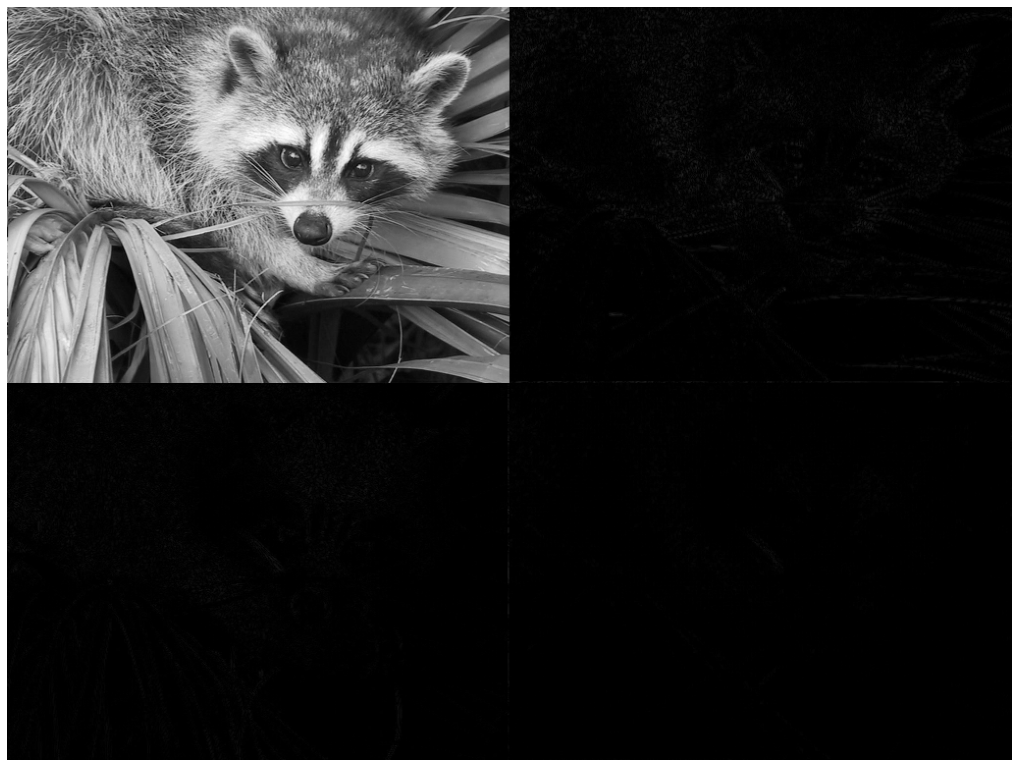

haar


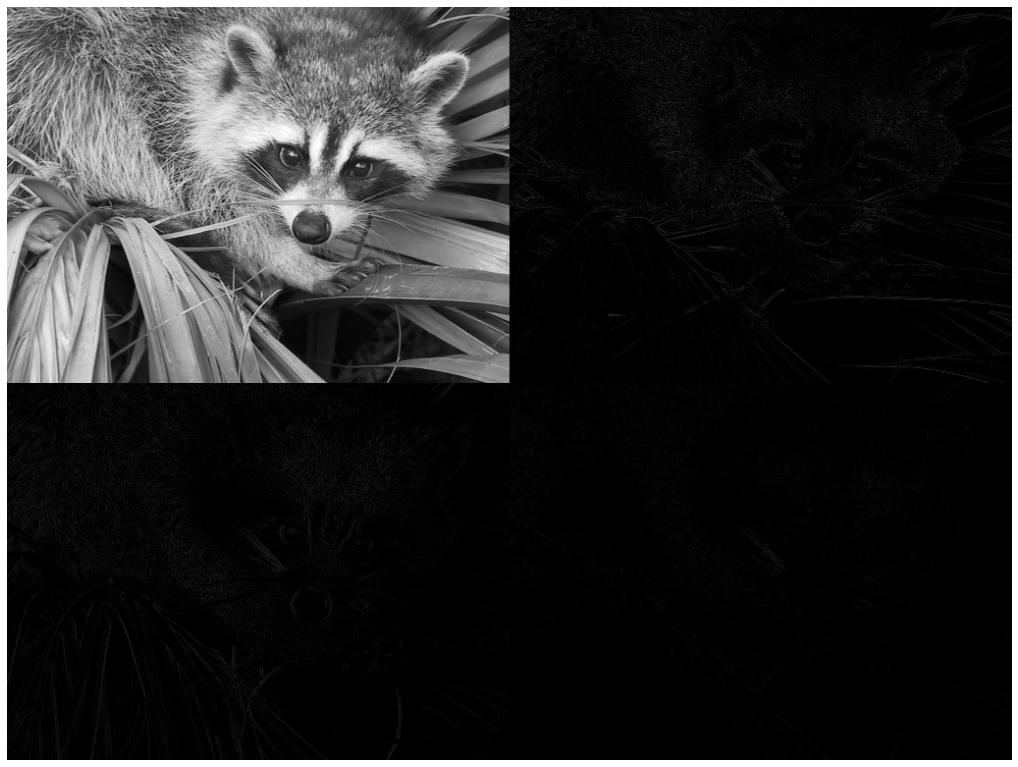

sym4


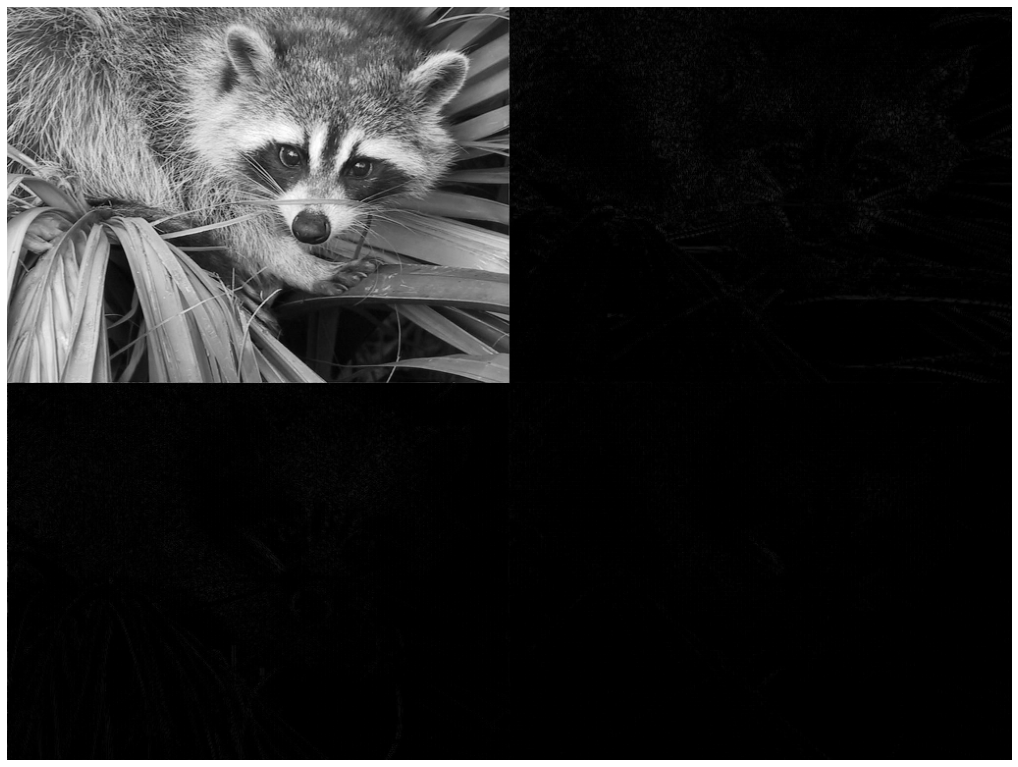

coif4


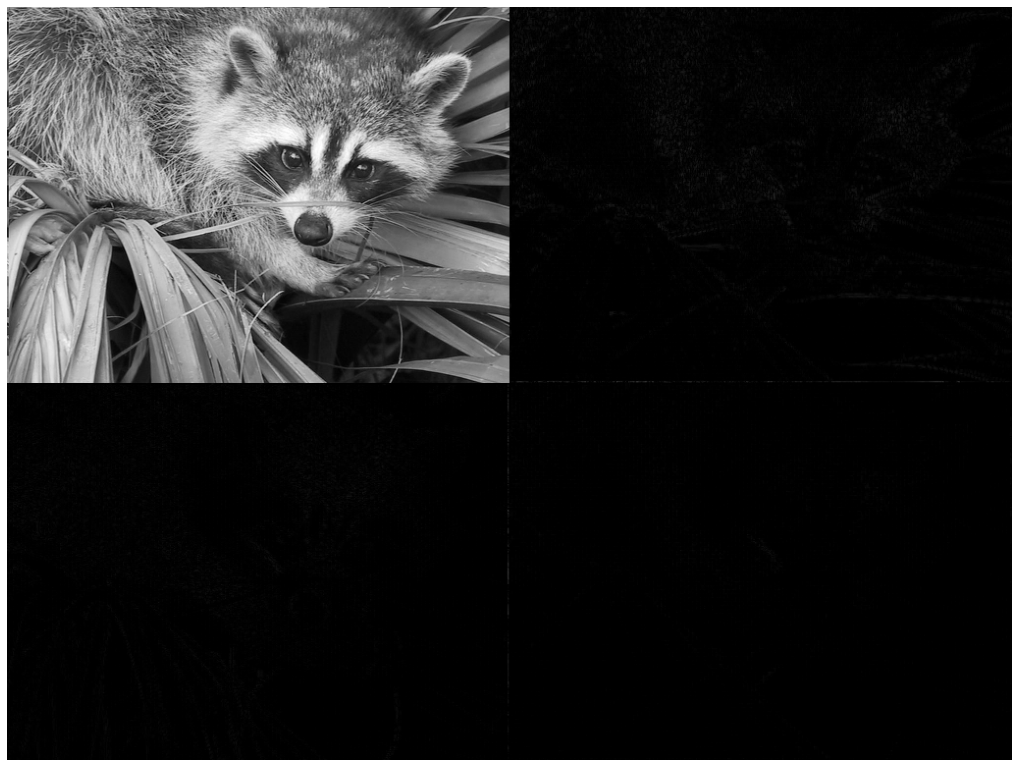

In [385]:
# ??? (Lab PDF says to plot all subbands)

# Plot LH (after 1 level of decomposition) using the Daubechies 4 wavelet.
print('db4')
show_subbands(racoon, 'db4')

# Plot LH (after 1 level of decomposition) using the Haar wavelet.
print('haar')
show_subbands(racoon, 'haar')

# Plot LH (after 1 level of decomposition) using the Symlet wavelet.
print('sym4')
show_subbands(racoon, 'sym4')

# Plot LH (after 1 level of decomposition) using the Coiflet wavelet.
print('coif4')
show_subbands(racoon, 'coif4')

# Problem 4:
Write two functions, one which performs hard thresholding and the second performs soft thresholding.

Perform hard and soft thresholding on noisy_darkhair.png and plot the resulting images together. Use the Daubechies 4 wavelets. For soft thresholding use $\tau=20$ and for hard thresholding use $\tau=40$.

In [386]:
def hard_threshold(coeffs, tau):
    """Clean the wavelet decomposition of an image using the hard
    thresholding technique, which sets all detail coefficients whose
    absolute value is less than tau to 0.
    
    Parameters:
        coeffs (list): A list of 2-D ndarrays in the form returned by
            pywt.wavedec2() (and other similar functions).
        tau (float): Threshold value.
        
    Returns:
        (list): A list of processed 2-D ndarrays in the same form as coeffs.
    """

    # Make a deep copy to avoid modifying the original coefficient arrays
    cleaned = copy.deepcopy(coeffs)
    
    for detail_tuple in cleaned[1:]:
        for detail in detail_tuple:
            # Map coefficients with magnitude less than tau to 0
            detail[np.abs(detail) < tau] = 0
    
    return cleaned
    
    
def soft_threshold(coeffs, tau):
    """Clean the wavelet decomposition of an image using the soft
    thresholding technique, which sets all detail coefficients whose
    absolute value is less than tau to 0 and all other detail 
    coefficients with value beta to beta - tau.
    
    Parameters:
        coeffs (list): A list of 2D ndarrays in the form returned by
            pywt.wavedec2() (and other similar functions).
        tau (float): Threshold value.
        
    Returns:
        (list): A list of processed 2D ndarrays in the same form as coeffs.
    """
    
    # Make a deep copy to avoid modifying the original coefficient arrays
    cleaned = copy.deepcopy(coeffs)
    
    for detail_tuple in cleaned[1:]:
        for detail in detail_tuple:
            # Map coefficients with magnitude less than tau to 0
            detail[np.abs(detail) < tau] = 0
            # Subtract tau from positive coefficients and add tau to negative coefficients
            detail[np.abs(detail) > 0] -= tau
            detail[np.abs(detail) < 0] += tau

    return cleaned

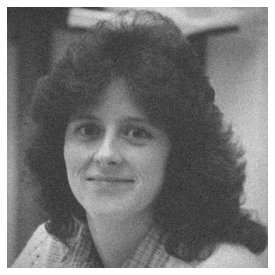

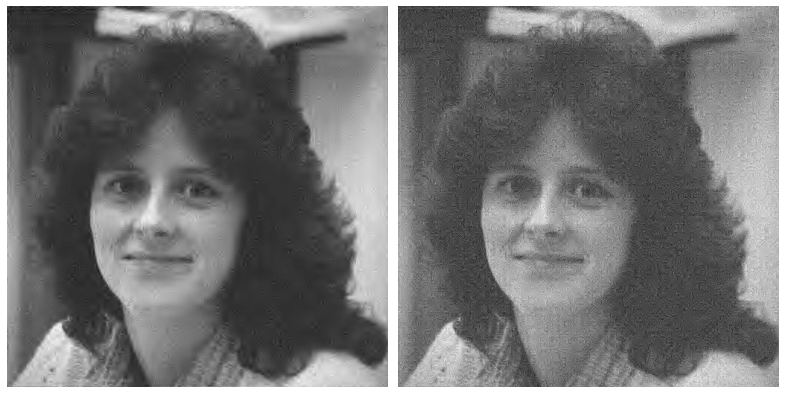

In [387]:
# Clean noisy_darkhair.png via soft and hard thresholding then plot both versions on different subplots.

# Reset fig size
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Get image and plot
image = imread('noisy_darkhair.png')
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Change fig size
plt.rcParams['figure.figsize'] = (14,7)

# Get db4 level 4 coefficients
coeffs = pywt.wavedec2(image, 'db4', mode='per', level=4)

# Thresholding
hard_coeffs = hard_threshold(coeffs, 40)
soft_coeffs = soft_threshold(coeffs, 20)

# Reconstructions
hard_rec = pywt.waverec2(hard_coeffs, 'db4', mode='per')
soft_rec = pywt.waverec2(soft_coeffs, 'db4', mode='per')

# Plot
fig, axs = plt.subplots(1,2)

axs[0].imshow(hard_rec, cmap='gray')
axs[0].axis('off')

axs[1].imshow(soft_rec, cmap='gray')
axs[1].axis('off')

# Adjust padding and show
plt.subplots_adjust(wspace=0)
plt.show()

# Problems 5-7
- Implement the `decompose()` and `recreate()` methods of the `WSQ` class.
- Implement the `quantize()` and `dequantize()` methods of the `WSQ` class.
- Implement the `get_ratio()` method of the `WSQ` class.
- Test your class by compressing then decompressing an image, plotting the image before and after compression and calculating the compression ratio.

In [388]:
class WSQ:
    """Perform image compression using the Wavelet Scalar Quantization
    algorithm. This class is a structure for performing the algorithm. To
    actually perform the compression and decompression, use the _compress
    and _decompress methods respectively. Note that all class attributes 
    are set to None in __init__, but their values are initialized in the 
    compress() method.
    
    Attributes:
        _pixels (int): Number of pixels in source image.
        _s (float): Scale parameter for image preprocessing.
        _m (float): Shift parameter for image preprocessing.
        _Q ((16, ), ndarray): Quantization parameters q for each subband.
        _Z ((16, ), ndarray): Quantization parameters z for each subband.
        _bitstrings (list): List of 3 BitArrays, giving bit encodings for 
            each group.
        _tvals (tuple): Tuple of 3 lists of bools, indicating which 
            subbands in each groups were encoded.
        _shapes (tuple): Tuple of 3 lists of tuples, giving shapes of each 
            subband in each group.
        _huff_maps (list): List of 3 dictionaries, mapping Huffman index to 
            bit pattern.
    """
    
    def __init__(self):
        self._pixels = None
        self._s = None
        self._m = None
        self._Q = None
        self._Z = None
        self._bitstrings = None
        self._tvals = None
        self._shapes= None
        self._huff_maps = None
        self._infoloss = None

    def compress(self, img, r, gamma=2.5):
        """The main compression routine. Compute and store a bitstring 
        representation of a compressed image, along with other values 
        needed for decompression.
        
        Parameters:
            img ((m,n), ndarray): Numpy array containing 8-bit integer 
                pixel values.
            r (float): Defines compression ratio. Between 0 and 1, smaller 
                numbers mean greater levels of compression.
            gamma (float): A parameter used in quantization.
        """
        self._pixels = img.size   # Store image size.
        # Process then decompose image into subbands.
        mprime = self.pre_process(img)
        subbands = self.decompose(img)
        # Calculate quantization parameters, quantize the image then group.
        self._Q, self._Z = self.get_bins(subbands, r, gamma)
        q_subbands = [self.quantize(subbands[i],self._Q[i],self._Z[i]) 
                      for i in range(16)]
        groups, self._shapes, self._tvals = self.group(q_subbands)
        
        # Complete the Huffman encoding and transfer to bitstring.
        huff_maps = []
        bitstrings = []
        for i in range(3):
            inds, freqs, extra = self.huffman_indices(groups[i])
            huff_map = huffman(freqs)
            huff_maps.append(huff_map)
            bitstrings.append(self.encode(inds, extra, huff_map))
        
        # Store the bitstrings and the Huffman maps.
        self._bitstrings = bitstrings
        self._huff_maps = huff_maps
        
    def pre_process(self, img):
        """Shift an image so that roughly half of its pixel values are 
        on either side of zero and fall between -128 and 128.
        
        Parameters:
            img ((m,n), ndarray): NumPy array containing 8-bit integer
                pixel values.
            
        Returns:
            ((m,n), ndarray): Processed NumPy array containing 8-bit
                integer pixel values.
        """
        self._m = img.mean()
        self._s = max(img.max()-self._m, self._m-img.min())/128
        return (img - self._m) / self._s
        
    def post_process(self, img):
        """Postprocess routine that reverses pre_process().
        
        Parameters:
            img ((m,n), ndarray): NumPy array containing 8-bit integer
                pixel values.
            
        Returns:
            ((m,n), ndarray): Unprocessed NumPy array containing 8-bit 
                integer pixel values.
        """
        return self._s * img + self._m
    
    def decompose(self, img):
        """Decompose an image into the WSQ subband pattern using the
        Coiflet1 wavelet.
        
        Parameters:
            ((m,n) ndarray): NumPy array holding the image to be 
                decomposed.
            
        Returns:
            (list): List of 16 NumPy arrays containing the WSQ 
                subbands in order.
        """
        # Get level 5 coefficients
        coeffs = pywt.wavedec2(img, 'coif1', mode='per', level=5)

        # Unpack coefficients into a single list
        return [coeffs[0]] + list(itertools.chain.from_iterable(coeffs[1:]))

    
    def recreate(self, subbands):
        """Recreate an image from the 16 WSQ subbands.
        
        Parameters:
            subbands (list): List of 16 NumPy arrays containing the WSQ 
                subbands in order.
            
        Returns:
            ((m,n) ndarray): NumPy array, the image recreated from the 
                WSQ subbands.
        """
        # Get the level and init a coeffs list
        level = (len(subbands)-1) // 3
        coeffs = [subbands[0]] + ([None] * level)

        # Pack coefficient arrays into three-tuples
        for i in range(1, level+1):
            coeffs[i] = (subbands[3*(i-1)+1], subbands[3*(i-1)+2], subbands[3*(i-1)+3]) 

        return pywt.waverec2(coeffs, 'coif1', mode='per')
    
    def get_bins(self, subbands, r, gamma):
        """Calculate quantization bin widths for each subband. These will 
        be used to quantize the wavelet coefficients.
        
        Parameters:
            subbands (list): List of 16 WSQ subbands.
            r (float): Compression parameter, determines the degree of 
                compression.
            gamma(float): Parameter used in compression algorithm.
            
        Returns:
            ((16, ) ndarray): Array of quantization step sizes.
            ((16, ) ndarray): Array of quantization coefficients.
        """
        subband_vars = np.zeros(16)
        fracs = np.zeros(16)
        
        for i in range(len(subbands)): # Compute subband variances.
            X,Y = subbands[i].shape
            fracs[i]=(X*Y)/(float(finger.shape[0]*finger.shape[1]))
            x = np.floor(X/8.).astype(int)
            y = np.floor(9*Y/32.).astype(int)
            Xp = np.floor(3*X/4.).astype(int)
            Yp = np.floor(7*Y/16.).astype(int)
            mu = subbands[i].mean()
            sigsq = (Xp*Yp-1.)**(-1)*((subbands[i][x:x+Xp, y:y+Yp]-mu)**2).sum()
            subband_vars[i] = sigsq
            
        A = np.ones(16)
        A[13], A[14] = [1.32]*2
        
        Qprime = np.zeros(16)
        mask = subband_vars >= 1.01
        Qprime[mask] = 10./(A[mask]*np.log(subband_vars[mask]))
        Qprime[:4] = 1
        Qprime[15] = 0
        
        K = []
        for i in range(15):
            if subband_vars[i] >= 1.01:
                K.append(i)
                
        while True:
            S = fracs[K].sum()
            P = ((np.sqrt(subband_vars[K])/Qprime[K])**fracs[K]).prod()
            q = (gamma**(-1))*(2**(r/S-1))*(P**(-1./S))
            E = []
            for i in K:
                if Qprime[i]/q >= 2*gamma*np.sqrt(subband_vars[i]):
                    E.append(i)
            if len(E) > 0:
                for i in E:
                    K.remove(i)
                continue
            break
            
        Q = np.zeros(16) # Final bin widths.
        for i in K:
            Q[i] = Qprime[i]/q
        Z = 1.2*Q
        
        return Q, Z
    
    def quantize(self, coeffs, Q, Z):
        """A uniform quantizer. Map wavelet coefficients to 
        integer values using the quantization parameters Q and Z.
        
        Parameters:
            coeffs ((m,n) ndarray): Contains the floating-point values to 
                be quantized.
            Q (float): The step size of the quantization.
            Z (float): The null-zone width (of the center quantization bin).
            
        Returns
            ((m,n) ndarray): NumPy array of the quantized values.
        """
        # Make a deep copy
        quantized = copy.deepcopy(coeffs)

        for subband in quantized:
            ### Map coefficients using the formula in the lab PDF
            if Q == 0:
                subband[:] = 0
            else:
                subband[np.abs(subband) <= Z/2] = 0

                subband[subband > 0] = np.floor(
                    (subband[subband > 0] - Z) / Q
                ) + 1

                subband[subband < 0] = np.ceil(
                    (subband[subband < 0] + Z) / Q
                ) - 1

        return quantized
        
    
    def dequantize(self, coeffs, Q, Z, C=0.44):
        """Approximately reverse the quantization effect carried out in quantize().
        
        Parameters:
            coeffs ((m,n) ndarray): Array of quantized coefficients.
            Q (float): The step size of the quantization.
            Z (float): The null-zone width (of the center quantization bin).
            C (float): Centering parameter, defaults to .44.
            
        Returns:
            ((m,n) ndarray): Array of dequantized coefficients.
        """
        # Make a deep copy
        dequantized = copy.deepcopy(coeffs)

        for subband in dequantized:
            ### Map coefficients using the formula in the lab PDF
            if Q == 0:
                subband[:] = 0
            else:
                # If a coeff is 0, no action needed

                subband[subband > 0] = (subband[subband > 0]-C)*Q + Z/2

                subband[subband < 0] = (subband[subband < 0]+C)*Q - Z/2

        return dequantized
    
    def group(self, subbands):
        """Split the quantized subbands into 3 groups.
        
        Parameters:
            subbands (list): Contains 16 NumPy arrays which hold the 
                quantized coefficients.
            
        Returns:
            (tuple): (g1,g2,g3) Each gi is a list of quantized coeffs 
                for group i.
            (tuple): (s1,s2,s3) Each si is a list of tuples which 
                contain the shapes for group i.
            (tuple): (s1,s2,s3) Each ti is a list of bools indicating 
                which subbands were included.
        """
        g1 = [] # This will hold the group 1 coefficients.
        s1 = [] # Keep track of the subband dimensions in group 1.
        t1 = [] # Keep track of which subbands were included.
        for i in range(10):
            s1.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g1.extend(subbands[i].ravel())
                t1.append(True)
            else: # The subband was not transmitted.
                t1.append(False)
                
        g2 = [] # This will hold the group 2 coefficients.
        s2 = [] # Keep track of the subband dimensions in group 2.
        t2 = [] # Keep track of which subbands were included.
        for i in range(10, 13):
            s2.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g2.extend(subbands[i].ravel())
                t2.append(True)
            else: # The subband was not transmitted.
                t2.append(False)
                
        g3 = [] # This will hold the group 3 coefficients.
        s3 = [] # Keep track of the subband dimensions in group 3.
        t3 = [] # Keep track of which subbands were included.
        for i in range(13,16):
            s3.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g3.extend(subbands[i].ravel())
                t3.append(True)
            else: # The subband was not transmitted.
                t3.append(False)
                
        return (g1,g2,g3), (s1,s2,s3), (t1,t2,t3)
            
    def ungroup(self, gs, ss, ts):
        """Re-create the subband list structure from the information stored
        in gs, ss, and ts.
        
        Parameters:
            gs (tuple): (g1,g2,g3) Each gi is a list of quantized coeffs 
                for group i.
            ss (tuple): (s1,s2,s3) Each si is a list of tuples which 
                contain the shapes for group i.
            ts (tuple): (s1,s2,s3) Each ti is a list of bools indicating 
                which subbands were included.
                
        Returns:
            (list): Contains 16 NumPy arrays holding quantized coefficients.
        """
        subbands1 = [] # The reconstructed subbands in group 1.
        i = 0
        for j, shape in enumerate(ss[0]):
            if ts[0][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands1.append(np.array(gs[0][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands1.append(np.zeros(shape))
                
        subbands2 = [] # The reconstructed subbands in group 2.
        i = 0
        for j, shape in enumerate(ss[1]):
            if ts[1][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands2.append(np.array(gs[1][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands2.append(np.zeros(shape))
                
        subbands3 = [] # the reconstructed subbands in group 3
        i = 0
        for j, shape in enumerate(ss[2]):
            if ts[2][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands3.append(np.array(gs[2][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands3.append(np.zeros(shape))
                
        subbands1.extend(subbands2)
        subbands1.extend(subbands3)
        return subbands1
    
    def huffman_indices(self, coeffs):
        """Calculate the Huffman indices from the quantized coefficients.
        
        Parameters:
            coeffs (list): Integer values that represent quantized 
                coefficients.
        
        Returns:
            (list): The Huffman indices.
            (ndarray): Array whose i-th entry gives the frequency of index i.
            (list): Contains zero run lengths and coefficient magnitudes for 
                exceptional cases.
        """
        N = len(coeffs)
        i = 0
        inds = []
        extra = []
        freqs = np.zeros(254)
        
        # Sweep through the quantized coefficients.
        while i < N:
            
            # First handle zero runs.
            zero_count = 0
            while coeffs[i] == 0:
                zero_count += 1
                i += 1
                if i >= N:
                    break
                    
            if zero_count > 0 and zero_count < 101:
                inds.append(zero_count - 1)
                freqs[zero_count - 1] += 1
            elif zero_count >= 101 and zero_count < 256: # 8 bit zero run.
                inds.append(104)
                freqs[104] += 1
                extra.append(zero_count)
            elif zero_count >= 256: # 16 bit zero run.
                inds.append(105)
                freqs[105] += 1
                extra.append(zero_count)
            if i >= N:
                break
                
            # now handle nonzero coefficients
            if coeffs[i] > 74 and coeffs[i] < 256: # 8 bit pos coeff.
                inds.append(100)
                freqs[100] += 1
                extra.append(coeffs[i])
            elif coeffs[i] >= 256: # 16 bit pos coeff.
                inds.append(102)
                freqs[102] += 1
                extra.append(coeffs[i])
            elif coeffs[i] < -73 and coeffs[i] > -256: # 8 bit neg coeff.
                inds.append(101)
                freqs[101] += 1
                extra.append(abs(coeffs[i]))
            elif coeffs[i] <= -256: # 16 bit neg coeff.
                inds.append(103)
                freqs[103] += 1
                extra.append(abs(coeffs[i]))
            else: # Current value is a nonzero coefficient in the range [-73, 74].
                inds.append(179 + coeffs[i])
                freqs[179 + coeffs[i].astype(int)] += 1
            i += 1
        
        return list(map(int,inds)), list(map(int,freqs)), list(map(int,extra))
    
    def indices_to_coeffs(self, indices, extra):
        """Calculate the coefficients from the Huffman indices plus extra 
        values.
        
        Parameters:
            indices (list): List of Huffman indices.
            extra (list): Indices corresponding to exceptional values.
            
        Returns:
            (list): Quantized coefficients recovered from the indices.
        """
        coeffs = []
        j = 0 # Index for extra array.
        
        for s in indices:
            if s < 100: # Zero count of 100 or less.
                coeffs.extend(np.zeros(s+1))
            elif s == 104 or s == 105: # Zero count of 8 or 16 bits.
                coeffs.extend(np.zeros(extra[j]))
                j += 1
            elif s in [100, 102]: # 8 or 16 bit pos coefficient.
                coeffs.append(extra[j]) # Get the coefficient from the extra list.
                j += 1
            elif s in [101, 103]: # 8 or 16 bit neg coefficient.
                coeffs.append(-extra[j]) # Get the coefficient from the extra list.
                j += 1
            else: # Coefficient from -73 to +74.
                coeffs.append(s-179)
        return coeffs
    
    def encode(self, indices, extra, huff_map):
        """Encode the indices using a Huffman map.
        
        Parameters:
            indices (list): Huffman Indices.
            extra (list): Indices corresponding to exceptional values.
            huff_map (dict): Dictionary that maps Huffman index to bit pattern.
            
        Returns:
            (BitArray object): Contains bit representation of the Huffman indices.
        """
        bits = bs.BitArray()
        j = 0 # Index for extra array.
        for s in indices: # Encode each Huffman index.
            bits.append('0b' + huff_map[s])
            
            # Encode extra values for exceptional cases.
            if s in [104, 100, 101]: # Encode as 8-bit ints.
                bits.append('uint:8={}'.format(int(extra[j])))
                j += 1
            elif s in [102, 103, 105]: # Encode as 16-bit ints.
                bits.append('uint:16={}'.format(int(extra[j])))
                j += 1
        return bits
    
    def decode(self, bits, huff_map):
        """Decode the bits using a Huffman map.
        
        Parameters:
            bits (BitArray object): Contains bit-encoded Huffman indices.
            huff_map (dict): Maps Huffman indices to bit pattern.
        
        Returns:
            (list): Decoded Huffman indices.
            (list): Decoded values corresponding to exceptional indices.
        """
        indices = []
        extra = []
        
        # Reverse the Huffman map to get the decoding map.
        dec_map = {v:k for k, v in huff_map.items()}
        
        # Wrap the bits in an object better suited to reading.
        bits = bs.ConstBitStream(bits)
        
        # Read each bit at a time, decoding as we go.
        i = 0 # The index of the current bit.
        pattern = '' # The current bit pattern.
        while i < bits.length:
            pattern += bits.read('bin:1') # Read in another bit.
            i += 1
            
            # Check if current pattern is in the decoding map.
            if pattern in dec_map:
                indices.append(dec_map[pattern]) # Insert Huffman index.
                
                # If an exceptional index, read next bits for extra value.
                if dec_map[pattern] in (100, 101, 104): # 8-bit int or 8-bit zero run length.
                    extra.append(bits.read('uint:8'))
                    i += 8
                elif dec_map[pattern] in (102, 103, 105): # 16-bit int or 16-bit zero run length.
                    extra.append(bits.read('uint:16'))
                    i += 16
                pattern = '' # Reset the bit pattern.
        return indices, extra
    
    def decompress(self):
        """Recover the uncompressed image from the compressed bistring 
        representation.
        
        Returns:
            ((m,n) ndaray): The recovered, uncompressed image.
        """
        # For each group, decode the bits, map from indices to coefficients.
        groups = []
        for i in range(3):
            indices, extras = self.decode(self._bitstrings[i], 
                                           self._huff_maps[i])
            groups.append(self.indices_to_coeffs(indices, extras))
            
        # Recover the subbands from the groups of coefficients.
        q_subbands = self.ungroup(groups, self._shapes, self._tvals)
        
        # Dequantize the subbands.
        subbands = [self.dequantize(q_subbands[i], self._Q[i], self._Z[i])
                    for i in range(16)]
        
        # Recreate the image.
        img = self.recreate(subbands)
        
        # Post-process, return the image.
        return self.post_process(img)
    
    def get_ratio(self):
        """Calculate the compression ratio achieved.
        
        Returns:
            (float): Ratio of number of bytes in the original image 
                to the number of bytes contained in the bitstrings.
        """
        
        # The denominator sums the lengths of all bitstrings
        return self._pixels * 8 / sum(map(len, self._bitstrings))

In [389]:
import queue
class HuffmanLeaf():
    """Leaf node for Huffman tree."""
    def __init__(self, symbol):
        self.symbol = symbol
        
    def make_map(self, huff_map, path):
        huff_map[self.symbol] = path
    
    def __str__(self):
        return str(self.symbol)
    
    def __lt__(self,other):
        return False
        
class HuffmanNode():
    """Internal node for Huffman tree."""
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def make_map(self, huff_map, path):
        """Traverse the Huffman tree to build the encoding map."""
        self.left.make_map(huff_map, path + '0')
        self.right.make_map(huff_map, path + '1')
        
    def __lt__(self,other):
        return False
        
def huffman(freqs):
    """
    Generate the Huffman tree for the given symbol frequencies.
    Return the map from symbol to bit pattern.
    """
    q = queue.PriorityQueue()
    for i in range(len(freqs)):
        leaf = HuffmanLeaf(i)
        q.put((freqs[i], leaf))
    while q.qsize() > 1:
        l1 = q.get()
        l2 = q.get()
        weight = l1[0] + l2[0]
        node = HuffmanNode(l1[1], l2[1])
        q.put((weight,node))
    root = q.get()[1]
    huff_map = dict()
    root.make_map(huff_map, '')
    return huff_map

18.591843040321336


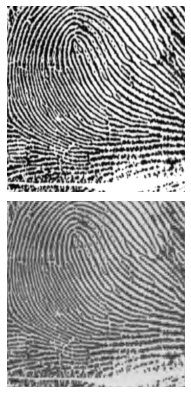

In [390]:
# Perform compression and decompression, print the compression ratio, and plot the image before and after.

# Try out different values of r between .1 to .9.
r = .7
finger = imread('uncompressed_finger.png')
wsq = WSQ()
wsq.compress(finger, r)
print(wsq.get_ratio())
new_finger = wsq.decompress()
plt.subplot(211)
plt.imshow(finger, cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(212)
plt.imshow(np.abs(new_finger), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplots_adjust(hspace=0.05)
plt.show()